# **Mount from Google drive**

This is needed to use the dataset that has been loaded on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# **Imports**

In [ ]:
import numpy as np
!pip install mne==0.22.0
import mne
from mne.io import concatenate_raws

import scipy
import os
from os import listdir
from scipy.io import loadmat
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 16.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
/usr/local/lib/python3.10/dist-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [ ]:
from scipy.signal.windows import blackman

In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [ ]:
import os
import scipy.io
import mne
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.io import savemat

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

RANDOM_SEED = 87

- 72 movie clips were chosen by a preliminary study which had tendency to induce happiness,  sadness, fear or neutral emotions.
- 15 subjects
- 3 sessions per subject on different daysd
- 24 trials per session
- 62 channel ESI NeuroScan System and SMI eye tracking glasses (ONLY use 8 channels as the Ant Neuro)

Ant Neuro Channels:  Fpz,Fz, Cz, Pz, C3, F3, F4, C4


## Due to the inter subject variability of the data it is best to only train the model per person with some sort of calibration.

# **Data of All Users**

In [ ]:
# Path to the directory containing session data
directory_path = "/content/drive/MyDrive/Colab Notebooks/eeg_raw_data/"

# Labels for each session
session_labels = {
    '1': [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3],
    '2': [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1],
    '3': [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
}

# List of channels I want to select
channel_list = ['Fpz','Fz', 'Cz', 'Pz', 'C3', 'F3', 'F4', 'C4']
ant_neuro_channel_list = [ 'Fpz','Fz', 'Cz', 'Pz', 'C3', 'F3', 'F4', 'C4']

sfreq = 200
n_channels = len(channel_list)
ch_names = [f'Channel_{i+1}' for i in range(n_channels)]
ch_types = ['eeg'] * n_channels

# **Load SEEDIV Dataset** - only 1 persons session with 24 trials

In [ ]:
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
channel_indices = [channel_list.index(ch) for ch in channel_list]

# Iterate over each session directory
for session_dir, labels in session_labels.items():
    session_path = os.path.join(directory_path, session_dir)
    data_with_labels = {}
    # Iterate over all mat files in the session directory
    for file_name in os.listdir(session_path):
        if file_name[0].isdigit() and file_name.endswith('.mat'):
            file_path = os.path.join(session_path, file_name)
            # Load the MATLAB file
            mat_data = scipy.io.loadmat(file_path)
            for key in mat_data.keys():
                if 'eeg' in key :
                    prefix = key.split('eeg')[0]
                    session_num_str = key.split('eeg')[-1]
                    if session_num_str.isdigit():
                        session_num = int(session_num_str)
                        eeg_data = mat_data[key][channel_indices, :]
                        label = labels[session_num - 1]
                        labelvector = np.full((eeg_data.shape[1],), label)
                        data_with_labels[session_dir+key] = (eeg_data, labelvector)



In [ ]:
data_with_labels.keys()

dict_keys(['3hql_eeg1', '3hql_eeg2', '3hql_eeg3', '3hql_eeg4', '3hql_eeg5', '3hql_eeg6', '3hql_eeg7', '3hql_eeg8', '3hql_eeg9', '3hql_eeg10', '3hql_eeg11', '3hql_eeg12', '3hql_eeg13', '3hql_eeg14', '3hql_eeg15', '3hql_eeg16', '3hql_eeg17', '3hql_eeg18', '3hql_eeg19', '3hql_eeg20', '3hql_eeg21', '3hql_eeg22', '3hql_eeg23', '3hql_eeg24', '3ldy_eeg1', '3ldy_eeg2', '3ldy_eeg3', '3ldy_eeg4', '3ldy_eeg5', '3ldy_eeg6', '3ldy_eeg7', '3ldy_eeg8', '3ldy_eeg9', '3ldy_eeg10', '3ldy_eeg11', '3ldy_eeg12', '3ldy_eeg13', '3ldy_eeg14', '3ldy_eeg15', '3ldy_eeg16', '3ldy_eeg17', '3ldy_eeg18', '3ldy_eeg19', '3ldy_eeg20', '3ldy_eeg21', '3ldy_eeg22', '3ldy_eeg23', '3ldy_eeg24', '3qyt_eeg1', '3qyt_eeg2', '3qyt_eeg3', '3qyt_eeg4', '3qyt_eeg5', '3qyt_eeg6', '3qyt_eeg7', '3qyt_eeg8', '3qyt_eeg9', '3qyt_eeg10', '3qyt_eeg11', '3qyt_eeg12', '3qyt_eeg13', '3qyt_eeg14', '3qyt_eeg15', '3qyt_eeg16', '3qyt_eeg17', '3qyt_eeg18', '3qyt_eeg19', '3qyt_eeg20', '3qyt_eeg21', '3qyt_eeg22', '3qyt_eeg23', '3qyt_eeg24', '3rx_eeg

In [ ]:
# Drop the first and last 3 seconds of each trial
for key,value in data_with_labels.items():
  eeg_data= value[0]
  label_vector = value[1]
  margin= 3*200
  label_vector=label_vector[margin+1:(eeg_data.shape[1]-margin)]
  eeg_data=eeg_data[:,margin+1:(eeg_data.shape[1]-margin)]
  data_with_labels[key]=(eeg_data,label_vector)


In [ ]:
# Segments trials into 4s windows with 50% overlap
def data_segmentation(eeg_data_list,label_vector_list):
  sfreq = 200
  window_samples = int(4*sfreq)
  step_samples = int(2*sfreq)

  segments =[]
  labels = []

  for start in range(0, eeg_data_list.shape[1] - window_samples, step_samples):
    end = start +window_samples
    segment = eeg_data_list[:,start:end]
    segment_labels=label_vector_list[start:end]

    label = np.floor(np.mean(segment_labels)).astype(int)
    segments.append(segment)
    labels.append(label)

  labels = np.array(labels, dtype = int)

  return segments,labels

In [ ]:
# MA filter
def rolling_window_2d(array):
    array_filtered = []
    for row_idx in range(array.shape[0]):
        row = array[row_idx,:]
        array_filtered.append(ma_filter(row,40))
    return np.array(array_filtered)


def ma_filter(x,w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [ ]:
# BP Filter
def bp_filter(data_array):

  info = mne.create_info(ch_names=channel_list, sfreq=200. , ch_types = 'eeg' )
  raw = mne.io.RawArray(data_array, info)
  filtered_raw = raw.filter(l_freq=0.5, h_freq=40)

  # Convert the filtered MNE RawArray back to a NumPy array
  filtered_data_array = filtered_raw.get_data()

  return data_array

In [ ]:
# #Extract Features
# def extract_features(eeg_data, sfreq, num_channels=8):
#     """
#     Extract features from EEG data.
#     """
#     # Initialize DataFrame with column names for features
#     column_titles = [f'PSD_{band}_{channel}' for band in ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta'] for channel in range(num_channels)]
#     df = pd.DataFrame(columns=column_titles)

#     # Calculate PSD for each channel
#     for channel in range(num_channels):
#         PSD, freq = psd(eeg_data[channel, :], sfreq)

#         PSD_features = [
#             np.mean(PSD[(freq >= 0.5) & (freq < 4.5)]),
#             np.mean(PSD[(freq >= 4.5) & (freq < 8.5)]),
#             np.mean(PSD[(freq >= 8.5) & (freq < 11.5)]),
#             np.mean(PSD[(freq >= 11.5) & (freq < 15.5)]),
#             np.mean(PSD[(freq >= 15.5) & (freq < 45)])
#         ]

#         # Assign the calculated features to the DataFrame using loc
#         for i, feature in enumerate(PSD_features):
#             column_name = f'PSD_{column_titles[i]}_{channel}'  # Construct column name
#             df.loc[0, column_name] = feature  # Assign feature to the DataFrame


#     return df


In [ ]:
def extract_features(eeg_data, sfreq, num_channels=8):
    """
    Extract features from EEG data, including DE.
    """
    # Define the desired bands
    bands = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta']

    # Initialize DataFrame with column names for features
    column_titles = [f'PSD_{band}_{channel}' for channel in range(num_channels) for band in bands]
    column_titles += [f'DE_{band}_{channel}' for channel in range(num_channels) for band in bands]  # Add DE columns
    df = pd.DataFrame(columns=column_titles)

    # Calculate PSD for each channel
    for channel in range(num_channels):
        PSD, freq = psd(eeg_data[channel, :], sfreq)

        # Calculate PSD features for each band
        for i, band in enumerate(bands):
            band_PSD = PSD[(freq >= 0.5) & (freq < 4.5)] if band == 'Delta' else \
                       PSD[(freq >= 4.5) & (freq < 8.5)] if band == 'Theta' else \
                       PSD[(freq >= 8.5) & (freq < 11.5)] if band == 'Alpha' else \
                       PSD[(freq >= 11.5) & (freq < 15.5)] if band == 'Sigma' else \
                       PSD[(freq >= 15.5) & (freq < 45)]  # Beta band

            # Calculate mean PSD for the band
            mean_band_PSD = np.mean(band_PSD)

            # Calculate DE for the band
            sigma_squared = np.var(band_PSD)
            de = 0.5 * np.log(2 * np.pi * np.e * sigma_squared)

            # Construct column name for DE
            de_column_name = f'DE_{band}_{channel}'

            # Construct column name for PSD
            column_name = f'PSD_{band}_{channel}'

            # Assign feature to the DataFrame
            df.loc[0, column_name] = mean_band_PSD
            df.loc[0, de_column_name] = de

    return df


In [ ]:
def psd(signal, fs, flip=False):
    """
    Compute the Power Spectral Density (PSD) of a signal.

    Parameters:
    - signal: 1D numpy array containing the signal.
    - fs: Sampling frequency of the signal.
    - flip_w

    Returns:
    - freqs: Array of sample frequencies.
    - psd: Power spectral density of the signal.
    """
    eeg_fft = np.fft.fft(signal * blackman(signal.shape[0]), axis=0)
    n = eeg_fft.shape[0]

    # get amplitude and phase
    amplitude, phase = 2 * np.absolute(eeg_fft)[:n // 2], np.angle(eeg_fft, deg=True)[:n // 2]

    # get frequencies
    if not flip:
        freq = np.fft.fftfreq(signal.shape[0], d=1.0/fs)[:n // 2]  # get positive frequency spectrum half
    else:
        freq = np.fft.fftfreq(signal.shape[0], d=1.0/fs)[-n // 2 - (n + 1) % 2::-1]  # get positive frequency spectrum and flip

    return amplitude, freq

In [ ]:
def filtering_and_feature_extraction(list, sfreq):
    dfs = []
    for segment in list:
        # BP
        segment = bp_filter(segment)

        # MA
        #segment = rolling_window_2d(segment)

        # Feature Extraction
        df = extract_features(segment, sfreq)

        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [ ]:
import warnings

# Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
for key, value in data_with_labels.items():
  eeg_data, label_vector = value #unpacks tuple onto 2 variables
  # epoch data
  segmented_eeg_data, segmented_label_vector = data_segmentation(eeg_data, label_vector)
  feature_df = filtering_and_feature_extraction(segmented_eeg_data, sfreq)

  data_with_labels[key] = (feature_df, segmented_label_vector)



In [ ]:
print(len(data_with_labels))
for key, value in data_with_labels.items():
    print(f"Key: {key}, Value: {value}")
for key, value in data_with_labels.items():
    print(f"Key: {key}, Value Type: {type(value)}")
for key, value in data_with_labels.items():
    print(f"Key: {key}, DataFrame Shape: {value[0].shape}")


Streaminguitvoer ingekort tot de laatste 5000 regels.
15   6.978039    6.71662  5.426586  
16   5.814004   6.277197  5.489021  
17   5.902606    6.42898  5.344761  
18   5.432375   7.263031  5.935499  
19   6.249131   5.885971  5.463314  
20    6.14115   6.511099  5.331927  
21    5.87129   6.704963  5.521096  
22   5.883436   5.771786  5.454596  
23   5.516122   6.498967  5.720906  
24    5.59593   6.117437  5.573409  
25   6.067641   6.280314  5.455114  
26   5.855973   6.394358  5.633173  
27   6.316367   6.175041  5.483691  
28   5.663287   5.844206  5.771894  
29   5.826276   5.433331  5.448237  
30   6.335327   6.372938  5.525034  
31   5.616773   6.026763  5.255669  
32   6.720734    6.43731  5.318783  
33   5.857022   6.288683  5.384004  
34   6.382893   6.171742  5.488195  
35   6.364072   6.278552  5.467914  
36   5.035597     6.3113  5.340631  
37    6.30713   5.336573    5.3588  
38   6.740689   5.888851  5.560128  
39   6.019933   5.794181  5.610721  
40   6.561568   5.949

In [ ]:
# Now we have a dictionary containing tuples of dataframes and labels
# We want to concatenate them into 1 df and 1 label array
eeg_data_df_concat = []
label_vector_array = []

for key, value in data_with_labels.items():
    eeg_data_df, label_vector = value
    eeg_data_df_concat.append(eeg_data_df)
    label_vector_array.append(label_vector)

eeg_data_df_concat = pd.concat(eeg_data_df_concat, axis=0)
label_vector_array = np.concatenate(label_vector_array,axis=0)


In [ ]:
print(eeg_data_df_concat.shape)
print(label_vector_array.shape)

(6196, 80)
(6196,)


In [ ]:
#save dataframe:
eeg_data_df_concat.to_csv('/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/eeg_data_df_concat.csv', index=False)
np.save('/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/label_vector_array.npy', label_vector_array)


In [ ]:
def tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test):

  start_time = time.time()
  cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
  tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                            scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

  tuned_clf.fit(x_train, y_train)
  print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
  prediction_train = tuned_clf.predict(x_train)
  accuracy_train = accuracy_score(y_train, prediction_train)
  prediction_test = tuned_clf.predict(x_test)
  accuracy_test = accuracy_score(y_test, prediction_test)

  print('Training Set: Classification report')
  print(classification_report(y_train, prediction_train))
  print('\nTest Set: Classification report')
  print(classification_report(y_test, prediction_test))

  class_labels = ["0", "1", "2", "3"]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  cmap = plt.get_cmap('Blues')
  cm_train = confusion_matrix(y_train, prediction_train)
  display = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_labels)
  display.plot(ax=ax1, cmap=cmap)
  ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')
  cm_test = confusion_matrix(y_test, prediction_test)
  display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
  display.plot(ax=ax2, cmap=cmap)
  ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

  plt.tight_layout()
  plt.show()

  end_time = time.time()  # Record the end time
  training_time = end_time - start_time  # Calculate the training time
  training_time = training_time / 60 # Convert training time to minutes
  print("Processing time: {:.2f} minutes".format(training_time))

  return tuned_clf, [accuracy_train,accuracy_test], cm_train, cm_test, training_time

In [ ]:
in_memory = True


In [ ]:
in_memory = False


In [ ]:
# Machine Learning applied
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.svm import SVC

if not in_memory:
  # Load concatenated DataFrame from CSV
  eeg_data_df_concat = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/eeg_data_df_concat.csv')
  # Load concatenated numpy array
  label_vector_array = np.load('/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/label_vector_array.npy')


df = pd.DataFrame(eeg_data_df_concat)
df['Label'] = label_vector_array

# Encode the labels if they are categorical
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Resampling
ros = RandomOverSampler(random_state=87)
X_resampled, y_resampled = ros.fit_resample(df.drop(columns=['Label']), df['Label'])

x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2,
                                                    stratify=y_resampled,
                                                    shuffle=True,
                                                    random_state=87)

print('Train set:')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set:')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set:
[[   0 1392]
 [   1 1392]
 [   2 1392]
 [   3 1392]]
Test set:
[[  0 348]
 [  1 348]
 [  2 348]
 [  3 348]]


In [ ]:
!pip install joblib

Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance'}
Training Set: Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1392
           1       1.00      1.00      1.00      1392
           2       1.00      1.00      1.00      1392
           3       1.00      1.00      1.00      1392

    accuracy                           1.00      5568
   macro avg       1.00      1.00      1.00      5568
weighted avg       1.00      1.00      1.00      5568


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.44      0.38      0.40       348
           1       0.43      0.36      0.39       348
           2       0.51      0.59      0.55       348
           3       0.53      0.59      0.56       348

    accuracy                           0.48      1392
   macro avg       0.48      0.48      0.48      1392
weighted avg       0.48      0.48      0.48      139

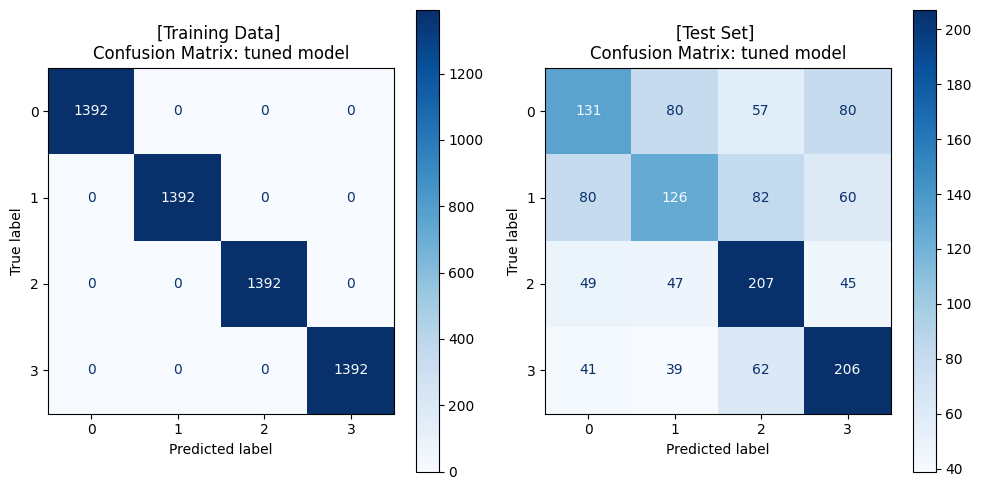

Processing time: 0.39 minutes


In [ ]:
base_clf = KNC()
clf_params = {'weights': ['uniform','distance'],
              'n_neighbors': [3, 5, 7]}
tuned_knn, accuracy_knn, cm_train_knn, cm_test_knn, processing_knn_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)


Best hyperparameters: {'C': 10, 'kernel': 'poly'}
Training Set: Classification report
              precision    recall  f1-score   support

           0       0.38      0.64      0.48      1392
           1       0.50      0.47      0.49      1392
           2       0.62      0.24      0.35      1392
           3       0.56      0.56      0.56      1392

    accuracy                           0.48      5568
   macro avg       0.52      0.48      0.47      5568
weighted avg       0.52      0.48      0.47      5568


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.35      0.59      0.44       348
           1       0.47      0.43      0.44       348
           2       0.50      0.22      0.30       348
           3       0.51      0.49      0.50       348

    accuracy                           0.43      1392
   macro avg       0.45      0.43      0.42      1392
weighted avg       0.45      0.43      0.42      1392



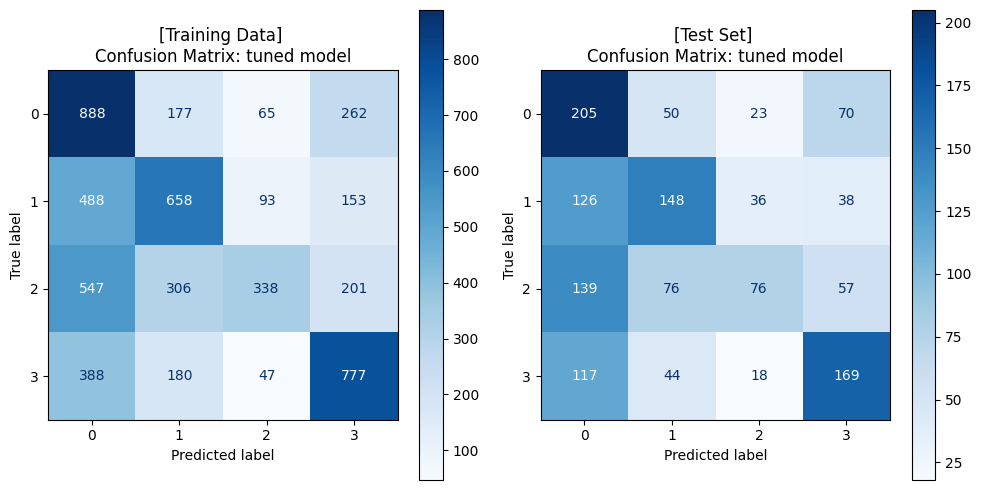

Processing time: 1.33 minutes


In [ ]:
base_clf = SVC()
clf_params = {'C': [0.1, 1, 10],
              'kernel': ['poly']}
tuned_svm, accuracy_svm, cm_train_svm, cm_test_svm, processing_svm_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)


Best hyperparameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'n_estimators': 100}
Training Set: Classification report
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1392
           1       0.95      0.96      0.96      1392
           2       0.98      0.96      0.97      1392
           3       0.97      0.98      0.97      1392

    accuracy                           0.96      5568
   macro avg       0.96      0.96      0.96      5568
weighted avg       0.96      0.96      0.96      5568


Test Set: Classification report
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       348
           1       0.62      0.60      0.61       348
           2       0.66      0.64      0.65       348
           3       0.72      0.76      0.74       348

    accuracy                           0.66      1392
   macro avg       0.66      0.66      0.66      1392
weighted avg  

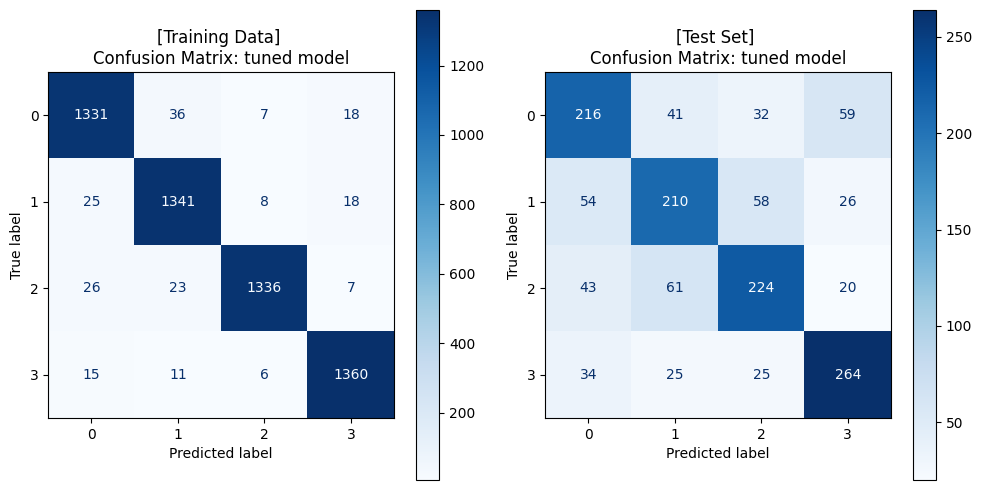

Processing time: 119.62 minutes


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

base_clf = GBC()
clf_params = {
    'loss': ['log_loss'],  # The loss function to be optimized.
    'n_estimators': [25, 50, 100],  # The number of boosting stages (trees)
    'learning_rate': [0.01, 0.05, 0.1],  # The step size shrinkage used to prevent overfitting
    'max_depth': [2, 3, 4, 5]}  # Maximum depth of the individual trees
tuned_gb, accuracy_gb, cm_train_gb, cm_test_gb, processing_gb_time = tune_train_test_pipeline(base_clf, clf_params, x_train, y_train, x_test, y_test)


In [ ]:
tuned_gb

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=87, shuffle=True),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['log_loss'], 'max_depth': [2, 3, 4, 5],
                         'n_estimators': [25, 50, 100]},
             refit='accuracy', scoring=['accuracy'])

In [ ]:
accuracy_gb

[0.9640804597701149, 0.6566091954022989]

In [ ]:
tuned_svm

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=87, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['poly']},
             refit='accuracy', scoring=['accuracy'])

In [ ]:
accuracy_svm

[0.45348419540229884, 0.4353448275862069]

In [ ]:
tuned_knn

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=87, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             refit='accuracy', scoring=['accuracy'])

In [ ]:
accuracy_knn

[1.0, 0.4813218390804598]

In [ ]:
import joblib
joblib.dump(tuned_knn, '/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/knn_checkpoint.pkl')


['/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/knn_checkpoint.pkl']

In [ ]:
em_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/knn_checkpoint.pkl')


In [ ]:
import joblib
joblib.dump(tuned_gb, '/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/gbc_checkpoint.pkl')


['/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/gbc_checkpoint.pkl']

In [ ]:
em_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/emotion_checkpoints/gbc_checkpoint.pkl')
